In [178]:
import csv
import math
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn import tree

In [179]:
#Class of ID3
class ID3:
    def __init__(self, datasetPath):
        self.tree = None
        self.pred = None
        self.datasetPath = datasetPath
        self.data = []
        self.classes = []
        self.numAttributes = -1
        self.attrValues = {}
        self.attributes = []
        
    def readDataset(self):
        with open(self.datasetPath, mode ='r') as file:
            csv_reader = csv.reader(file, delimiter=',')
            for index,row in enumerate(csv_reader):
                if index == 0:
                    self.attributes = [x.strip() for x in list(row[:len(row)-1])]
                    self.numAttributes = len(self.attributes)
                    for i in range(self.numAttributes):
                        self.attrValues[self.attributes[i]] = []
                    continue
            
                for i in range(self.numAttributes):
                    if row[i].strip() not in self.attrValues[self.attributes[i]]:
                        self.attrValues[self.attributes[i]].append(row[i].strip())
                 
                # Get attribute values dict {x :.... , y : ...}
                
                try:
                    if row[self.numAttributes].strip() not in self.classes:
                        self.classes.append(row[self.numAttributes].strip())
                except:
                    pass
                
                line = [x.strip() for x in list(row)]
                if line!= [] or line != [""]:
                    self.data.append(line)
                
                # line = [x_value,y_value,class]
                # Get data list =[[x_value1,y_value1,class1],[x_value2,y_value2,class2],....]
                
            for key,val in self.attrValues.items():
                flag = 0
                for x in val:
                    try:
                        p = float(x)
                        flag = 1
                        break
                    except:
                        pass
                if flag == 1:
                    self.attrValues[key] = ["continuous"]
    
    
    def print_dataset(self):
        
        dataset=pd.read_csv('ass2.csv')
        dataset=pd.DataFrame(data=dataset.iloc[:,0:3].values,columns=["X","Y","Class"])

        dataset_encoded=dataset.iloc[:,0:3]
        le=LabelEncoder()

        #for i in dataset_encoded:
        #    dataset_encoded[i]=le.fit_transform(dataset_encoded[i])
        print(dataset)

        #Feature Set
        X=dataset_encoded.iloc[:,0:2].values
        print(X)


        # Label Set
        y=dataset_encoded.iloc[:,2].values
        print("Label Set(y): \n", y,"\n")
        
        X_train = X.tolist()
        y_train = y.tolist()

        print("\nX_train : ",X_train)
        print("Y_train : ",y_train,"\n")
        
        
    
    def preprocessData(self):
        for index,row in enumerate(self.data):
            for attr_index in range(self.numAttributes):
                if(not self.isAttrDiscrete(self.attributes[attr_index])):
                    self.data[index][attr_index] = float(self.data[index][attr_index])
                
                
    def isAttrDiscrete(self, attribute):
        if attribute not in self.attributes:
            raise ValueError("Attribute not listed")
        elif len(self.attrValues[attribute]) == 1 and self.attrValues[attribute][0] == "continuous":
            return False
        else:
            return True
    
    def allSameClass(self, data):
        for row in data:
            if row[-1] != data[0][-1]:
                return False
        # If all same, then returning the class value
        return data[0][-1]
    
    def generateTree(self):
        self.tree = self.recursiveGenerateTree(self.data, self.attributes)
        
    def recursiveGenerateTree(self, curData, curAttributes):
        allSame = self.allSameClass(curData)
        
        if len(curData) == 0:
            return Node(True, "Fail", None)
        
        elif allSame is not False:
            return Node(True, allSame, None)
        
        elif len(curAttributes) == 0:
            majClass = self.getMajClass(curData)
            return Node(True, majClass, None)
        
        else:
            (best, best_threshold, splitted) = self.splitAttribute(curData, curAttributes)
            remainingAttributes = curAttributes[:]
            node = Node(False, best, best_threshold)
            node.children = [self.recursiveGenerateTree(subset, remainingAttributes) for subset in splitted]
            return node
        
    def getMajClass(self, curData):
        freq = [0]*len(self.classes)
        for row in curData:
            index = self.classes.index(row[-1])
            freq[index] += 1
        maxInd = freq.index(max(freq))
        return self.classes[maxInd]
    
    def splitAttribute(self, curData, curAttributes):
        splitted = []
        maxGain = -1*float("inf")
        best_attribute = -1
        best_threshold = None
        
        for attribute in curAttributes:
            indexOfAttribute = self.attributes.index(attribute)
            if self.isAttrDiscrete(attribute):
                pass
                    
            else:
                curData.sort(key = lambda x: x[indexOfAttribute])
                indexOfClass = len(curData[0])-1
                #print(curData)
                #exit()
                for j in range(0, len(curData) - 1):
                    if curData[j][indexOfClass] != curData[j+1][indexOfClass]:
                        threshold = (curData[j][indexOfAttribute] + curData[j+1][indexOfAttribute]) / 2
                        less = []
                        greater = []
                        for row in curData:
                            if(row[indexOfAttribute] > threshold):
                                greater.append(row)
                            else:
                                less.append(row)
                        e = self.gain(curData, [less, greater])
                        if e > maxGain:
                            splitted = [less, greater]
                            maxGain = e
                            best_attribute = attribute
                            best_threshold = threshold
        return (best_attribute,best_threshold,splitted)
    
    def gain(self,unionSet, subsets):
        S = len(unionSet)
        impurityBeforeSplit = self.entropy(unionSet)
        weights = [len(subset)/S for subset in subsets]
        impurityAfterSplit = 0
        for i in range(len(subsets)):
            impurityAfterSplit += weights[i]*self.entropy(subsets[i])
        totalGain = impurityBeforeSplit - impurityAfterSplit
        # gainratio=totalGain/impurityAfterSplit
        return totalGain
    
    def entropy(self, dataSet):
        S = len(dataSet)
        if S == 0:
            return 0
        num_classes = [0 for i in self.classes]
        for row in dataSet:
            classIndex = list(self.classes).index(row[-1])
            num_classes[classIndex] += 1
        num_classes = [x/S for x in num_classes]
        ent = 0
        for num in num_classes:
            ent += num*self.log(num)
        return ent*-1
    
    def log(self, x):
        if x==0:
            return 0
        else:
            return math.log(x,2)
        
    def printTree(self):
        print("The Decision Tree :\n")
        self.printNode(self.tree)
        
    def printNode(self, node, indent=""):
        if not node.isLeaf:
            if node.threshold is None:
                pass
            else:
                leftChild = node.children[0]
                rightChild = node.children[1]
                if leftChild.isLeaf:
                    print(indent + node.label + " <= " + str(node.threshold) + " : " + leftChild.label)
                else:
                    print(indent + node.label + " <= " + str(node.threshold)+" : ")
                    self.printNode(leftChild, indent + "    ")
                
                if rightChild.isLeaf:
                    print(indent + node.label + " > " + str(node.threshold) + " : " + rightChild.label)
                else:
                    print(indent + node.label + " > " + str(node.threshold) + " : ")
                    self.printNode(rightChild , indent + "    ")
        pass
    
    def predict(self,test_dataset):
        row = []
        print("\nThe Result of test dataset For ID3 : ")
        # for i in range(len(self.attributes)):
            # inp = input(str(self.attributes[i])+' = ').strip()
            # row.append(inp)     
        # self.prediction(self.tree, row)
        # print('Prediction Result :',self.pred)
        # pass
        
        with open(test_dataset,mode ='r') as test_dataset:
            readCSV = csv.reader(test_dataset)
            for i in readCSV:
                try:
                    row.append(float(i[0]))
                    row.append(float(i[1]))
                    self.prediction(self.tree, row)
                    print("For [x,y] = ",row ,' prediction class =',self.pred)
                    row = []
                except:
                    pass
        pass
    
    def prediction(self, node, row):
        if not node.isLeaf:
            if node.threshold is None:
                pass
                
            else:
                #continuous (have threshold value)
                indexOfAttribute = self.attributes.index(node.label)
                inp = float(row[indexOfAttribute])
                leftChild = node.children[0]
                rightChild = node.children[1]
                if inp <= node.threshold:
                    if leftChild.isLeaf:
                        self.pred = leftChild.label
                    else:
                        self.prediction(leftChild, row)
                else:
                    if rightChild.isLeaf:
                        self.pred = rightChild.label
                    else:
                        self.prediction(rightChild, row)
        pass
    
    def evaluate(self, dataPath):
        data = pd.read_csv(dataPath)
        length = len(data)
        true = []
        predicted = []
        for i in range(length):
            row = [str(i).strip() for i in list(data.iloc[i])[:-1]]
            true.append(str(data.iloc[i][-1]).strip())
            self.prediction(self.tree, row)
            predicted.append(self.pred)
        
        accurate = 0
        error = 0
        for i in range(length):
            if true[i] == predicted[i]:
                accurate += 1
            else:
                error += 1
                
        print('Accuracy:', (accurate/(accurate+error))*100, '%')
            
    def viewTruePred(self, dataPath):
        data = pd.read_csv(dataPath)
        length = len(data)
        true = []
        predicted = []
        for i in range(length):
            row = [str(i).strip() for i in list(data.iloc[i])[:-1]]
            true.append(data.iloc[i][-1].strip())
            self.prediction(self.tree, row)
            predicted.append(self.pred)
            
        print('True label', 'Predicted label')
        for i in range(length):
            print(true[i], predicted[i])

class Node:
    def __init__(self, isLeaf, label, threshold):
        self.label = label
        self.threshold = threshold
        self.isLeaf = isLeaf
        self.children = []


In [180]:

# model1 = ID3()
# mdli = model1.id3()
# tree.plot_tree(mdli);

# print("The attribute of feature vector : ")
# x = input('X = ').strip()
# y = input('Y = ').strip() 
# pr=mdli.predict([[x,y]]) 
# print("Prediction Result : ",pr)


In [181]:
#Class of CART
class CART:
    
    def __init__(self):
        self.tree = None
        self.pred = None
        self.data = []
        self.classes = []
        self.numAttributes = -1
        self.attrValues = {}
        self.attributes = []
    
    def cart(self,datapath):
    
        dataset=pd.read_csv(datapath)
        dataset=pd.DataFrame(data=dataset.iloc[:,0:3].values,columns=["X","Y","Class"])

        dataset_encoded=dataset.iloc[:,0:3]
        le=LabelEncoder()

        print(dataset)

        #Feature Set
        X=dataset_encoded.iloc[:,0:2].values
        print("Feature Set: \n",X)


        # Label Set
        y=dataset_encoded.iloc[:,2].values
        print("Label Set(y): \n", y)

        X_train = X.tolist()
        y_train = y.tolist()

        print("\nX_train : ",X_train)
        print("Y_train : ",y_train,"\n")
        
        mdl_tp = 'gini'
        
        model = DecisionTreeClassifier(criterion= 'gini')
        model.fit(X_train,y_train)

        tree.plot_tree(model);

        return model
    
    def input_func(self,test_data_set):
        print("\nThe Result of test dataset For CART : ")
        with open(test_data_set, mode='r') as test_dataset:
            readCSV = csv.reader(test_dataset)
            x=[]
            y=[]
            for i in readCSV:
                # print("i",i)
                try:
                    x.append(float(i[0]))
                    y.append(float(i[1]))
                    #print("x_y",(x),"  ",y)
                except:
                    pass
        return x,y


In [182]:
# For C4.5
class C4_5:

    def __init__(self, datasetPath):
        self.tree = None
        self.pred = None
        self.datasetPath = datasetPath
        self.data = []
        self.classes = []
        self.numAttributes = -1
        self.attrValues = {}
        self.attributes = []

    def readDataset(self):
        with open(self.datasetPath, mode ='r') as file:
            csv_reader = csv.reader(file, delimiter=',')
            for index,row in enumerate(csv_reader):
                if index == 0:
                    self.attributes = [x.strip() for x in list(row[:len(row)-1])]
                    self.numAttributes = len(self.attributes)
                    for i in range(self.numAttributes):
                        self.attrValues[self.attributes[i]] = []
                    continue
            
                for i in range(self.numAttributes):
                    if row[i].strip() not in self.attrValues[self.attributes[i]]:
                        self.attrValues[self.attributes[i]].append(row[i].strip())
                
                #print("**********",self.attrValues)
                
                try:
                    if row[self.numAttributes].strip() not in self.classes:
                        self.classes.append(row[self.numAttributes].strip())
                except:
                    pass
                
                line = [x.strip() for x in list(row)]
                if line!= [] or line != [""]:
                    self.data.append(line)
                    
                #print("**********",self.data)
                
                # line = [x_value,y_value,class]
                # Get data list =[[x_value1,y_value1,class1],[x_value2,y_value2,class2],....]

                    
            for key,val in self.attrValues.items():
                flag = 0
                for x in val:
                    try:
                        p = float(x)
                        flag = 1
                        break
                    except:
                        pass
                if flag == 1:
                    self.attrValues[key] = ["continuous"]
            
            # print("**********",self.attrValues)
        
    def print_dataset(self):
        
        dataset=pd.read_csv('ass2.csv')
        dataset=pd.DataFrame(data=dataset.iloc[:,0:3].values,columns=["X","Y","Class"])

        dataset_encoded=dataset.iloc[:,0:3]
        le=LabelEncoder()

        print(dataset)

        #Feature Set
        X=dataset_encoded.iloc[:,0:2].values
        print(X)


        # Label Set
        y=dataset_encoded.iloc[:,2].values
        print("Label Set(y): \n", y,"\n")
        
        X_train = X.tolist()
        y_train = y.tolist()

        print("\nX_train : ",X_train)
        print("Y_train : ",y_train,"\n")
        
    
    def preprocessData(self):
        for index,row in enumerate(self.data):
            for attr_index in range(self.numAttributes):
                if(not self.isAttrDiscrete(self.attributes[attr_index])):
                    self.data[index][attr_index] = float(self.data[index][attr_index])

    def printTree(self):
        print("The Decision Tree :\n")
        self.printNode(self.tree)

    def printNode(self, node, indent=""):
        if not node.isLeaf:
            if node.threshold is None:
                #Discrete
                for index,child in enumerate(node.children):
                    if child.isLeaf:
                        print(indent + node.label + " = " + attributes[index] + " : " + child.label)
                    else:
                        print(indent + node.label + " = " + attributes[index] + " : ")
                        self.printNode(child, indent + "   ")
            else:
                #Continuous-numerical
                leftChild = node.children[0]
                rightChild = node.children[1]
                if leftChild.isLeaf:
                    print(indent + node.label + " <= " + str(node.threshold) + " : " + leftChild.label)
                else:
                    print(indent + node.label + " <= " + str(node.threshold)+" : ")
                    self.printNode(leftChild, indent + "   ")

                if rightChild.isLeaf:
                    print(indent + node.label + " > " + str(node.threshold) + " : " + rightChild.label)
                else:
                    print(indent + node.label + " > " + str(node.threshold) + " : ")
                    self.printNode(rightChild , indent + "   ")



    def generateTree(self):
        self.tree = self.recursiveGenerateTree(self.data, self.attributes)

    def recursiveGenerateTree(self, curData, curAttributes):
        allSame = self.allSameClass(curData)

        if len(curData) == 0:
            return Node(True, "Fail", None)
        elif allSame is not False:
            #Return a node with that class
            return Node(True, allSame, None)
        elif len(curAttributes) == 0:
            #Return a node with the majority class
            majClass = self.getMajClass(curData)
            return Node(True, majClass, None)
        else:
            (best,best_threshold,splitted) = self.splitAttribute(curData, curAttributes)
            remainingAttributes = curAttributes[:]
            # RemainingAttributes.remove(best)
            node = Node(False, best, best_threshold)
            node.children = [self.recursiveGenerateTree(subset, remainingAttributes) for subset in splitted]
            return node

    def getMajClass(self, curData):
        freq = [0]*len(self.classes)
        for row in curData:
            index = self.classes.index(row[-1])
            freq[index] += 1
        maxInd = freq.index(max(freq))
        return self.classes[maxInd]


    def allSameClass(self, data):
        for row in data:
            if row[-1] != data[0][-1]:
                return False
        return data[0][-1]

    def isAttrDiscrete(self, attribute):
        if attribute not in self.attributes:
            raise ValueError("Attribute not listed")
        elif len(self.attrValues[attribute]) == 1 and self.attrValues[attribute][0] == "continuous":
            return False
        else:
            return True

    def splitAttribute(self, curData, curAttributes):
        splitted = []
        maxEnt = -1*float("inf")
        best_attribute = -1
        #None for discrete attributes, threshold value for continuous attributes
        best_threshold = None
        for attribute in curAttributes:
            indexOfAttribute = self.attributes.index(attribute)
            if self.isAttrDiscrete(attribute):
                #Split curData into n-subsets,
                #Where n is the number of different values of attribute i. 
                #Choose the attribute with the max gain
                valuesForAttribute = self.attrValues[attribute]
                subsets = [[] for a in valuesForAttribute]
                for row in curData:
                    for index in range(len(valuesForAttribute)):
                        if row[i] == valuesForAttribute[index]:
                            subsets[index].append(row)
                            break
                e = gain(curData, subsets)
                if e > maxEnt:
                    maxEnt = e
                    splitted = subsets
                    best_attribute = attribute
                    best_threshold = None
            else:
                #Sort the data according to the column.
                #Then try all possible adjacent pairs.
                #Choose the one that yields maximum gain.
                curData.sort(key = lambda x: x[indexOfAttribute])
                for j in range(0, len(curData) - 1):
                    if curData[j][indexOfAttribute] != curData[j+1][indexOfAttribute]:
                        threshold = (curData[j][indexOfAttribute] + curData[j+1][indexOfAttribute]) / 2
                        less = []
                        greater = []
                        for row in curData:
                            if(row[indexOfAttribute] > threshold):
                                greater.append(row)
                            else:
                                less.append(row)
                        e = self.gain(curData, [less, greater])
                        if e >= maxEnt:
                            splitted = [less, greater]
                            maxEnt = e
                            best_attribute = attribute
                            best_threshold = threshold
        return (best_attribute,best_threshold,splitted)

    def gain(self,unionSet, subsets):
        #Input : data and disjoint subsets of it
        #Output : information gain
        S = len(unionSet)
        impurityBeforeSplit = self.entropy(unionSet)
        weights = [len(subset)/S for subset in subsets]
        impurityAfterSplit = 0
        for i in range(len(subsets)):
            impurityAfterSplit += weights[i]*self.entropy(subsets[i])
        #Calculate total gain
        totalGain = impurityBeforeSplit - impurityAfterSplit
        # gainratio=totalGain/impurityAfterSplit
        return totalGain

    def entropy(self, dataSet):
        S = len(dataSet)
        if S == 0:
            return 0
        num_classes = [0 for i in self.classes]
        for row in dataSet:
            classIndex = list(self.classes).index(row[-1])
            num_classes[classIndex] += 1
        num_classes = [x/S for x in num_classes]
        ent = 0
        for num in num_classes:
            ent += num*self.log(num)
        return ent*-1
    
    
    # Prediction function 
    def predict(self,test_data_set):
        row = []
        print("\nThe Result of test dataset For C4.5 : ")
        
        # for i in range(len(self.attributes)):
            # inp = input(str(self.attributes[i])+' = ').strip()
            # row.append(inp)
        # self.prediction(self.tree, row)
        # print('Prediction Result :',self.pred)
        # pass
        
        with open(test_data_set,mode ='r') as test_dataset:
            readCSV = csv.reader(test_dataset)
            for i in readCSV:
                try:
                    row.append(float(i[0]))
                    row.append(float(i[1]))
                    self.prediction(self.tree, row)
                    print("For [x,y] = ",row ,' prediction class =',self.pred)
                    row = []
                except:
                    pass
        pass
    
    

    def prediction(self, node, row):
        if not node.isLeaf:
            if node.threshold is None:
                pass

            else:
                #Continuous (have threshold value)
                indexOfAttribute = self.attributes.index(node.label)
                inp = float(row[indexOfAttribute])
                leftChild = node.children[0]
                rightChild = node.children[1]
                if inp <= node.threshold:
                    if leftChild.isLeaf:
                        self.pred = leftChild.label
                    else:
                        self.prediction(leftChild, row)
                else:
                    if rightChild.isLeaf:
                        self.pred = rightChild.label
                    else:
                        self.prediction(rightChild, row)
        pass
    
    
    
    def evaluate(self, dataPath):
        data = pd.read_csv(dataPath)
        length = len(data)
        true = []
        predicted = []
        for i in range(length):
            row = [str(i).strip() for i in list(data.iloc[i])[:-1]]
            true.append(str(data.iloc[i][-1]).strip())
            self.prediction(self.tree, row)
            predicted.append(self.pred)
        
        accurate = 0
        error = 0
        for i in range(length):
            if true[i] == predicted[i]:
                accurate += 1
            else:
                error += 1
                
        print('Accuracy:', (accurate/(accurate+error))*100, '%')
            
    def viewTruePred(self, dataPath):
        data = pd.read_csv(dataPath)
        length = len(data)
        true = []
        predicted = []
        for i in range(length):
            row = [str(i).strip() for i in list(data.iloc[i])[:-1]]
            true.append(data.iloc[i][-1].strip())
            self.prediction(self.tree, row)
            predicted.append(self.pred)
            
        print('True label', 'Predicted label')
        for i in range(length):
            print(true[i], predicted[i])


    #For log calculation
    def log(self, x):
        if x == 0:
            return 0
        else:
            return math.log(x,2)


        
class Node:
    def __init__(self,isLeaf, label, threshold):
        self.label = label
        self.threshold = threshold
        self.isLeaf = isLeaf
        self.children = []
        

In [183]:
# import pdb
# # from c45 import C45

# c45 = C4_5("E:/4th year 2nd term/Pattern Recognition/Assignment_3_LAB/lab/ass2.data", "E:/4th year 2nd term/Pattern Recognition/Assignment_3_LAB/lab/ass2.names")
# c45.fetchData()
# c45.preprocessData()
# c45.generateTree()
# c45.printTree()
# c45.predict()

Input your Algorithm name (For ID3,C4.5,CART) : CART

For CART Algorithm : 
         X      Y Class
0    2.491  2.176   w_1
1    1.053  0.677   w_1
2    5.792  3.425   w_1
3    2.054 -1.467   w_1
4     0.55   4.02   w_1
5    4.218 -2.075   w_2
6   -1.156 -2.992   w_2
7   -4.435  1.408   w_2
8   -1.794 -2.838   w_2
9   -2.137 -2.473   w_2
10   -2.52  0.483   w_3
11  -1.163  3.161   w_3
12 -13.438  2.414   w_3
13  -4.467  2.298   w_3
14  -3.711  4.364   w_3
Feature Set: 
 [[2.491 2.176]
 [1.053 0.677]
 [5.792000000000001 3.425]
 [2.0540000000000003 -1.4669999999999999]
 [0.55 4.02]
 [4.218 -2.075]
 [-1.156 -2.992]
 [-4.435 1.4080000000000001]
 [-1.794 -2.838]
 [-2.137 -2.4730000000000003]
 [-2.52 0.483]
 [-1.163 3.161]
 [-13.437999999999999 2.414]
 [-4.467 2.298]
 [-3.7110000000000003 4.364]]
Label Set(y): 
 ['w_1' 'w_1' 'w_1' 'w_1' 'w_1' 'w_2' 'w_2' 'w_2' 'w_2' 'w_2' 'w_3' 'w_3'
 'w_3' 'w_3' 'w_3']

X_train :  [[2.491, 2.176], [1.053, 0.677], [5.792000000000001, 3.425], [2.0540000000000

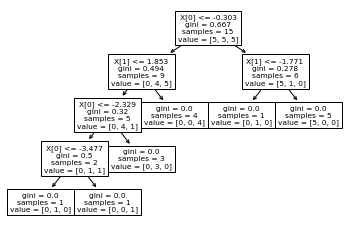

In [188]:
algo = input('\033[1m'+ 'Input your Algorithm name (For ID3,C4.5,CART) : ').strip()

model = ID3('ass2.csv')
if algo == 'ID3':
    
    print( "\nFor ID3 Algorithm : ")
    
    modelid3 = ID3('ass2.csv')
    modelid3.readDataset()
    modelid3.print_dataset()
    modelid3.preprocessData()
    modelid3.generateTree()
    modelid3.printTree()
    modelid3.predict('test_data.csv')
    modelid3.evaluate('ass2.csv')
    
#     print("The attribute of feature vector : ")
#     x = input('X = ').strip()
#     y = input('Y = ').strip() 
#     pr=mdli.predict([[x,y]]) 
#     print("Prediction Result : ",pr)
#     tree.plot_tree(mdli);

    
elif algo == 'C4.5':
    
    print("\nFor C4.5 Algorithm : ")
    
    import pdb
    # from c45 import C45

    mdlc45 = C4_5('ass2.csv')
    mdlc45.print_dataset()
    mdlc45.readDataset()
    mdlc45.preprocessData()
    mdlc45.generateTree()
    mdlc45.printTree()
    mdlc45.predict('test_data.csv')
    mdlc45.evaluate('ass2.csv')
    
elif algo == 'CART':
    
    print( "\nFor CART Algorithm : ")
    
    model2 = CART()
    mdlc = model2.cart('ass2.csv')
    modelcart = model
   
    x,y=model2.input_func('test_data.csv')
    
    for i in range(0,len(m)-1):  
        pr=mdlc.predict([[x[i],y[i]]]) 
        print("For [x,y] = [",x[i],y[i],"] prediction class : ",pr)
    
    modelcart.readDataset()
    modelcart.preprocessData()
    modelcart.generateTree()
    modelcart.evaluate('ass2.csv')
    print("\nThe Decision Tree :\n")

else:
    print('\033[1m'+ algo," Algorithm is not here. Run again and choose  in the above threes. ")

In [185]:
"""
Test data = [-2.799,0.746] = w3
            [2.491,2.176] = w1
            [4.218,-2.075] = w2
"""

'\nTest data = [-2.799,0.746] = w3\n            [2.491,2.176] = w1\n            [4.218,-2.075] = w2\n'